# Finding Outliers

In [28]:
import os

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

## Dataset

In [29]:
# Read training and test data

earnings_df = pd.read_csv("fraud_data_new.csv")

In [30]:
earnings_df.sample(10)

,company_id,dsri,gmi,aqi,sgi,depi,sgai,accr,levi,status
271,272,0.982399,0.437722,1.272203,1.079165,1.083422,1.063880,-0.006795,0.909211,No
267,268,1.131973,1.025395,1.188680,1.037420,1.058965,1.126558,-0.023080,1.238712,No
337,338,0.997089,1.039686,1.164788,0.949885,0.937083,1.063756,-0.114373,0.869986,No
819,820,0.878192,1.034653,1.009800,1.264674,1.113221,0.961243,-0.043266,0.604094,No
813,814,0.763811,1.000000,0.944159,1.068849,1.001558,0.811021,-0.019393,1.027553,No
467,468,1.358566,0.964225,0.875006,1.112179,0.933889,1.093259,0.001488,1.231214,No
177,178,1.266839,0.991746,0.269330,1.258005,0.899355,1.094208,0.155993,1.096545,No
676,677,1.098178,0.914156,-21.733841,1.081502,1.037164,1.248606,-0.052488,1.012263,No
1004,1005,0.638864,0.867393,0.977323,0.915770,0.996810,1.414592,-0.133139,0.878225,No
349,350,1.140638,1.263143,1.042637,1.074269,1.085709,0.828750,-0.066014,1.137012,No


In [31]:
np.sum(earnings_df.isna())

,0
company_id,0
dsri,0
gmi,0
aqi,0
sgi,0
depi,0
sgai,0
accr,0
levi,0
status,0


In [32]:
earnings_df['status'] = earnings_df['status'].map(lambda x: 1 if x == 'Yes' else 0)

In [33]:
earnings_df.sample(10)

,company_id,dsri,gmi,aqi,sgi,depi,sgai,accr,levi,status
252,253,1.324866,1.029047,0.950079,1.149739,1.158751,0.989049,0.028927,1.026832,0
1081,1082,0.986057,0.915148,0.961982,1.082596,1.105168,0.977569,-0.022034,0.960679,0
451,452,1.095621,0.934434,1.060402,1.089929,1.693510,0.431984,0.039490,0.964463,0
1145,1146,0.959333,1.051191,0.104806,0.824473,1.034004,1.078397,-0.131211,1.228164,0
99,100,1.012862,1.085507,0.560647,1.065678,1.019738,0.940729,-0.076135,1.129354,0
1049,1050,1.051705,0.872625,0.876143,0.992461,1.069804,1.537680,-0.030608,1.007776,0
105,106,0.921783,0.633391,1.137255,1.087306,1.043915,0.890928,-0.069158,0.923594,0
499,500,1.110995,1.485703,0.750406,1.367325,1.075798,1.031398,0.106144,1.118756,0
1070,1071,1.597559,1.000000,0.284496,1.234437,1.031705,0.837703,0.111509,1.139763,0
571,572,1.260441,1.002283,0.973067,1.028707,1.339349,1.054595,-0.062013,0.742874,0


In [34]:
earnings_df.status.value_counts()

,count
status,
0,1200
1,39


In [35]:
x_features = list(earnings_df.columns)
x_features.remove('company_id')
x_features.remove('status')

In [36]:
x_features

['dsri', 'gmi', 'aqi', 'sgi', 'depi', 'sgai', 'accr', 'levi']

In [37]:
earnings_df[x_features].shape

(1239, 8)

In [38]:
earnings_df['status'].shape

(1239,)

# Algorithms

In [39]:
# Create a results dataframe to store and later compare results

def fit_model(input_data, model_fn, model_args=None, threshold=0.15, labels=None):
    return model_fn(input_data, model_args, threshold, labels)

def predict_model(input_data, model, predict_fn, threshold=None):
    return predict_fn(input_data, model, threshold)

## Isolation Forest

In [40]:
def fit_isolation_forest(input_data, args=None, threshold=0.5, labels=None):
    model = IsolationForest(n_estimators = 200,
                            contamination=threshold,
                            random_state=100)

    model.fit(input_data)

    return model

def predict_isolation_forest(input_data, model, threshold=None):
    y_pred = model.predict(input_data)
    y_pred = [1 if pred == -1 else 0 for pred in y_pred]

    return y_pred

In [41]:
if_model = fit_model(earnings_df[x_features], fit_isolation_forest)

In [42]:
scores = if_model.decision_function(earnings_df[x_features])

In [43]:
scores

array([-0.05268533, -0.25093424,  0.04205907, ...,  0.03213279,
        0.07097401,  0.05717345])

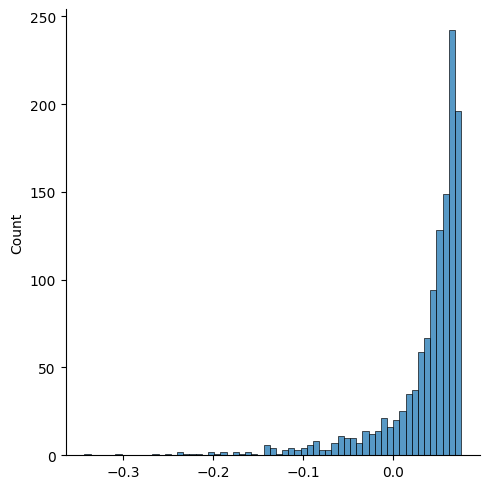

In [44]:
sn.displot(scores);

In [45]:
y_pred_test = predict_model(earnings_df[x_features],
                            if_model,
                            predict_isolation_forest)

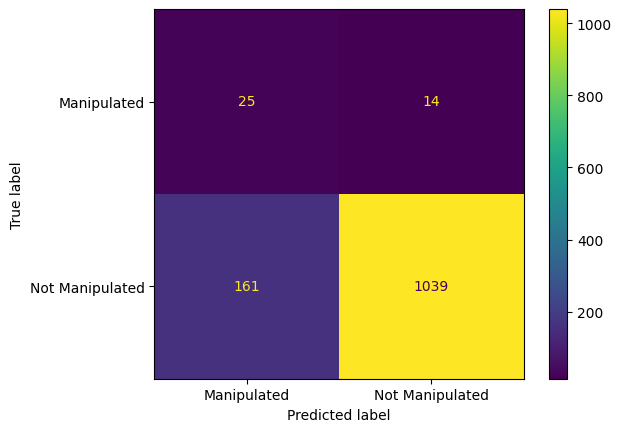

In [46]:
cm = confusion_matrix(earnings_df['status'],
                      y_pred_test,
                      labels = [1, 0])
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['Manipulated', 'Not Manipulated'])
cm_plot.plot();

In [47]:
print("Classification Report:\n",
      classification_report(earnings_df['status'],
                            y_pred_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.92      1200
           1       0.13      0.64      0.22        39

    accuracy                           0.86      1239
   macro avg       0.56      0.75      0.57      1239
weighted avg       0.96      0.86      0.90      1239



## Adjusting Contamination Values

In [48]:
threshold_vals = list(np.arange(0.05,
                                0.20,
                                0.01))

In [49]:
from sklearn.metrics import recall_score

In [50]:
threshold_recall = []

for threshold in threshold_vals:
    if_model = fit_model(earnings_df[x_features],
                         fit_isolation_forest,
                         threshold = threshold)

    y_pred_test = predict_model(earnings_df[x_features],
                                if_model,
                                predict_isolation_forest)
    threshold_recall.append([np.round(threshold, 3),
                             np.round(recall_score(earnings_df['status'],
                                                   y_pred_test), 2)])

In [51]:
threshold_recall_df = pd.DataFrame(threshold_recall,
                                   columns = ['threshold', 'recall'])

In [52]:
threshold_recall_df.sort_values("recall", ascending = False)

,threshold,recall
15,0.20,0.72
14,0.19,0.72
13,0.18,0.69
12,0.17,0.69
11,0.16,0.64
9,0.14,0.64
10,0.15,0.64
6,0.11,0.62
7,0.12,0.62
5,0.10,0.62


In [53]:
if_model = fit_model(earnings_df[x_features],
                     fit_isolation_forest,
                     threshold = 0.20)

y_pred_test = predict_model(earnings_df[x_features],
                            if_model,
                            predict_isolation_forest)

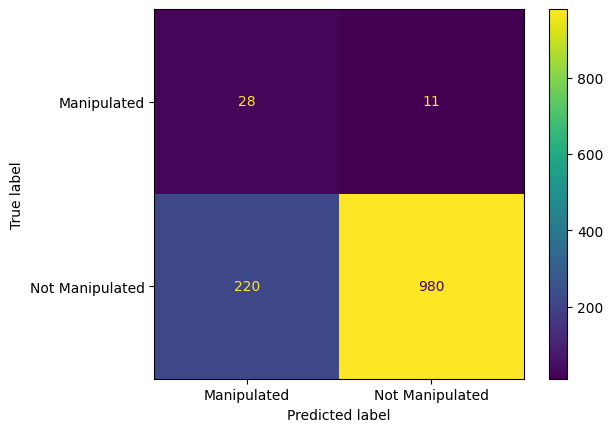

In [54]:
cm = confusion_matrix(earnings_df['status'],
                      y_pred_test, labels = [1, 0])
cm_plot = ConfusionMatrixDisplay(cm,
                                 display_labels=['Manipulated', 'Not Manipulated'])
cm_plot.plot();